In [1]:
import os
import time
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import pandas as pd
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import models
from torch.utils.data import DataLoader, Dataset
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.stats import skew
from skimage.feature import local_binary_pattern
import joblib
from PIL import Image
from tkinter import filedialog, Tk


In [2]:
# Set seed untuk memastikan hasil reproducible
import random
seed_value = 42

random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
torch.cuda.manual_seed(seed_value)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
# Pastikan device didefinisikan sebelum digunakan
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# Path dataset
train_path = r"D:\KULIAH IT\Skripsi\uji\train"
test_path = r"D:\KULIAH IT\Skripsi\uji\test"

In [5]:
# Ambil nama folder sebagai class_names (diurutkan secara alfabetis)
class_names = sorted(os.listdir(train_path))
joblib.dump(class_names, "D:/KULIAH IT/Skripsi/CODE/class_names.pkl")
print(f"Class Names: {class_names}")

Class Names: ['bacterial blight', 'brown spot', 'green mite', 'healthy', 'mosaic']


In [6]:
# Fungsi untuk menampilkan jumlah sampel pada setiap label
def count_samples(dataset_path):
    categories = os.listdir(dataset_path)
    counts = {category: len(os.listdir(os.path.join(dataset_path, category))) for category in categories}
    return counts

Train dataset sample counts: {'bacterial blight': 800, 'brown spot': 800, 'green mite': 800, 'healthy': 800, 'mosaic': 800}
Test dataset sample counts: {'bacterial blight': 200, 'brown spot': 200, 'green mite': 200, 'healthy': 200, 'mosaic': 200}


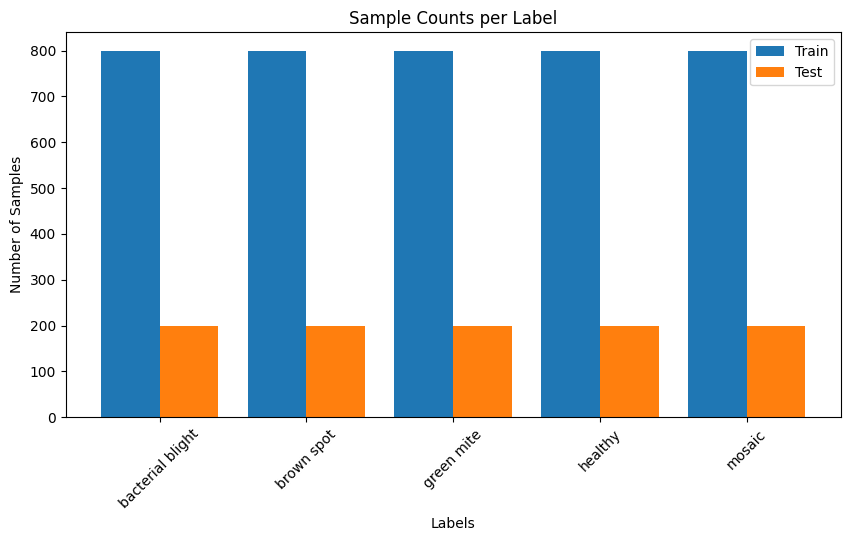

In [7]:
# Menampilkan jumlah sampel
def visualize_sample_counts(train_counts, test_counts):
    labels = list(train_counts.keys())
    train_values = list(train_counts.values())
    test_values = list(test_counts.values())
    
    x = np.arange(len(labels))
    width = 0.4
    
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.bar(x - width/2, train_values, width, label='Train')
    ax.bar(x + width/2, test_values, width, label='Test')
    
    ax.set_xlabel('Labels')
    ax.set_ylabel('Number of Samples')
    ax.set_title('Sample Counts per Label')
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=45)
    ax.legend()
    plt.show()

train_counts = count_samples(train_path)
test_counts = count_samples(test_path)
print("Train dataset sample counts:", train_counts)
print("Test dataset sample counts:", test_counts)
visualize_sample_counts(train_counts, test_counts)

Visualisasi dataset training:


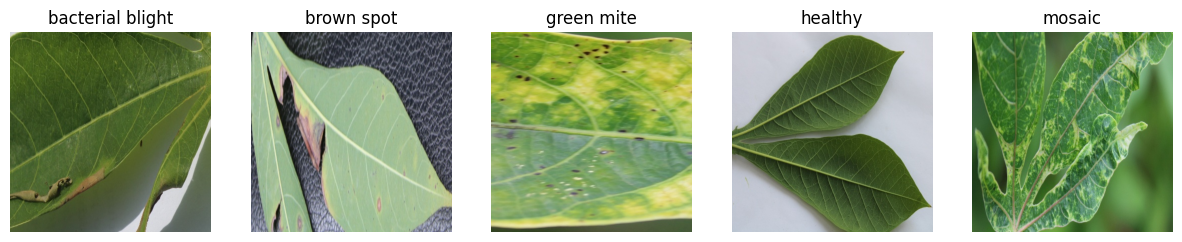

Visualisasi dataset testing:


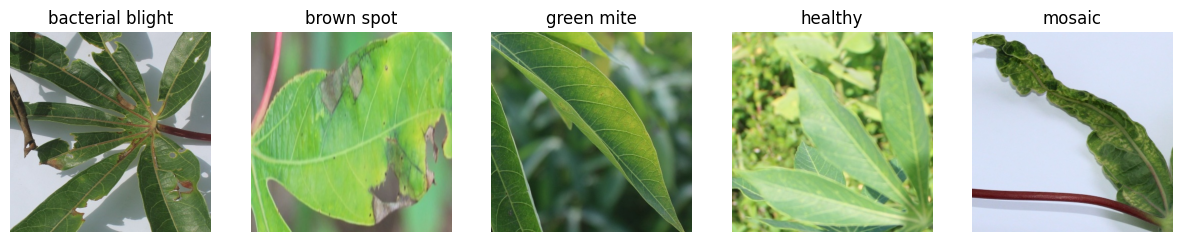

In [8]:
# Visualisasi dataset
def visualize_dataset(dataset_path):
    categories = os.listdir(dataset_path)
    fig, axes = plt.subplots(1, len(categories), figsize=(15, 5))
    for i, category in enumerate(categories):
        folder_path = os.path.join(dataset_path, category)
        file_name = os.listdir(folder_path)[0]
        file_path = os.path.join(folder_path, file_name)
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        axes[i].imshow(image)
        axes[i].set_title(category)
        axes[i].axis("off")
    plt.show()

print("Visualisasi dataset training:")
visualize_dataset(train_path)
print("Visualisasi dataset testing:")
visualize_dataset(test_path)

# SVM

In [9]:
# Parameter LBP
LBP_RADIUS = 1
LBP_POINTS = 8 * LBP_RADIUS
LBP_METHOD = 'uniform'

def extract_features_svm(image_path):
    image = cv2.imread(image_path)
    if image is None:
        print(f"Warning: Gagal membaca gambar {image_path}")
        return None  # Skip gambar yang tidak bisa dibaca

    image = cv2.resize(image, (224, 224))
    
    # Histogram warna (3 channel, 8 bin per channel)
    hist = cv2.calcHist([image], [0, 1, 2], None, [8, 8, 8],
                        [0, 256, 0, 256, 0, 256])
    hist = cv2.normalize(hist, hist).flatten()

    # Color moments (mean, std, skewness untuk setiap channel RGB)
    color_moments = []
    for i in range(3):  # B, G, R
        channel = image[:, :, i]
        color_moments.append(np.mean(channel))
        color_moments.append(np.std(channel))
        color_moments.append(skew(channel.flatten()))
    color_moments = np.array(color_moments)

    # LBP (Local Binary Pattern) dari grayscale image
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    lbp = local_binary_pattern(gray, LBP_POINTS, LBP_RADIUS, method=LBP_METHOD)
    
    # Histogram LBP
    n_bins = 10
    lbp_hist, _ = np.histogram(lbp.ravel(), bins=n_bins, range=(0, n_bins))
    lbp_hist = lbp_hist.astype("float")
    lbp_hist /= (lbp_hist.sum() + 1e-6)  # Normalisasi

    # Gabungkan semua fitur
    combined_features = np.concatenate([hist, color_moments, lbp_hist])

    return combined_features

In [10]:
# Fungsi untuk memuat dataset untuk SVM
def load_dataset_svm(dataset_path):
    data, labels = [], []
    categories = os.listdir(dataset_path)
    for category in categories:
        folder_path = os.path.join(dataset_path, category)
        if not os.path.isdir(folder_path):
            continue
        for file_name in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file_name)
            if file_path.lower().endswith(('.png', '.jpg', '.jpeg')):
                features = extract_features_svm(file_path)
                if features is not None:
                    data.append(features)
                    labels.append(categories.index(category))
    return np.array(data), np.array(labels)

In [11]:
# Load dataset untuk SVM
data_train_svm, labels_train_svm = load_dataset_svm(train_path)
data_test_svm, labels_test_svm = load_dataset_svm(test_path)

In [12]:
# Menampilkan jumlah data
print(f"Jumlah data latih: {len(data_train_svm)}")
print(f"Jumlah data uji: {len(data_test_svm)}")

# Menampilkan shape dan contoh data
print(f"Shape fitur latih: {data_train_svm.shape}")
print(f"Shape fitur uji: {data_test_svm.shape}")

# Menampilkan 1 contoh data dan label
print("Contoh fitur (latih):", data_train_svm[0][:10])  # Tampilkan 10 nilai pertama
print("Labelnya:", labels_train_svm[0])

Jumlah data latih: 4000
Jumlah data uji: 1000
Shape fitur latih: (4000, 531)
Shape fitur uji: (1000, 531)
Contoh fitur (latih): [0.00203456 0.00040691 0.         0.         0.         0.
 0.         0.         0.00259407 0.02568634]
Labelnya: 0


In [13]:
# Standarisasi fitur
scaler = StandardScaler()
data_train_svm = scaler.fit_transform(data_train_svm)
data_test_svm = scaler.transform(data_test_svm)

In [14]:
# Reduksi dimensi dengan PCA
pca = PCA(n_components=50)
data_train_svm = pca.fit_transform(data_train_svm)
data_test_svm = pca.transform(data_test_svm)

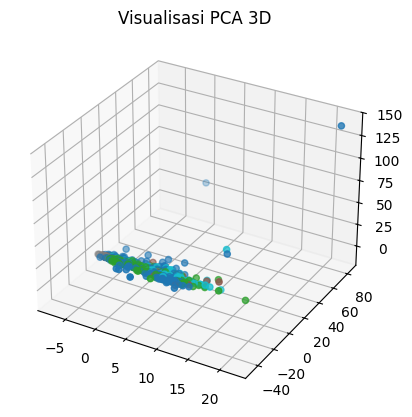

In [15]:
from mpl_toolkits.mplot3d import Axes3D

pca_vis = PCA(n_components=3).fit_transform(data_train_svm)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(pca_vis[:, 0], pca_vis[:, 1], pca_vis[:, 2], c=labels_train_svm, cmap='tab10')
plt.title("Visualisasi PCA 3D")
plt.show()

In [16]:
# Hyperparameter tuning SVM
param_grid = {
    'C': [1, 10],  # Regularisasi
    'gamma': ['scale', 'auto'],  # Parameter untuk kernel RBF
    'kernel': ['linear', 'rbf', 'poly']  # Jenis kernel
}

grid = GridSearchCV(SVC(), param_grid, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)
grid.fit(data_train_svm, labels_train_svm)

print("Best parameters:", grid.best_params_)
best_svm = grid.best_estimator_

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters: {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}


In [17]:
# Menampilkan hasil dalam bentuk DataFrame
results_df = pd.DataFrame(grid.cv_results_)

# Menampilkan hanya kolom penting: parameter dan skor rata-rata
results_table = results_df[['params', 'mean_test_score', 'std_test_score', 'rank_test_score']]
results_table.sort_values(by='rank_test_score')

,params,mean_test_score,std_test_score,rank_test_score
10,"{'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}",0.81625,0.019154,1
11,"{'C': 10, 'gamma': 'auto', 'kernel': 'poly'}",0.79125,0.016125,2
7,"{'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}",0.78575,0.013337,3
5,"{'C': 1, 'gamma': 'auto', 'kernel': 'poly'}",0.76425,0.019049,4
4,"{'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}",0.76350,0.012435,5
1,"{'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}",0.72075,0.013124,6
8,"{'C': 10, 'gamma': 'scale', 'kernel': 'poly'}",0.70775,0.009533,7
6,"{'C': 10, 'gamma': 'scale', 'kernel': 'linear'}",0.68850,0.013426,8
9,"{'C': 10, 'gamma': 'auto', 'kernel': 'linear'}",0.68850,0.013426,8
0,"{'C': 1, 'gamma': 'scale', 'kernel': 'linear'}",0.68625,0.014252,10


In [18]:
# Training SVM dengan parameter terbaik
svm = SVC(**grid.best_params_)
svm.fit(data_train_svm, labels_train_svm)

SVC(C=10, gamma='auto')

In [19]:
# Simpan model SVM, PCA, dan Scaler
joblib.dump(svm, "D:/KULIAH IT/Skripsi/CODE/svm_model.pkl")
joblib.dump(pca, "D:/KULIAH IT/Skripsi/CODE/pca.pkl")
joblib.dump(scaler, "D:/KULIAH IT/Skripsi/CODE/scaler.pkl")

['D:/KULIAH IT/Skripsi/CODE/scaler.pkl']

In [20]:
# Load Model SVM, PCA, dan Scaler
svm_model = joblib.load("D:/KULIAH IT/Skripsi/CODE/svm_model.pkl")
pca = joblib.load("D:/KULIAH IT/Skripsi/CODE/pca.pkl")
scaler = joblib.load("D:/KULIAH IT/Skripsi/CODE/scaler.pkl")

Confusion Matrix (SVM):


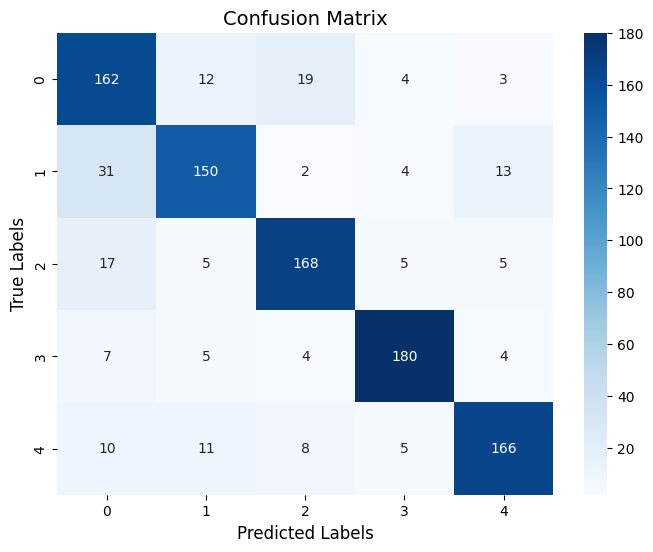

In [21]:
# Evaluasi SVM
y_pred_svm = svm_model.predict(data_test_svm)
y_pred_svm = svm.predict(data_test_svm)
print("Confusion Matrix (SVM):")
cms=confusion_matrix(labels_test_svm, y_pred_svm)

# Visualisasi Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cms, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels', fontsize=12)
plt.ylabel('True Labels', fontsize=12)
plt.title('Confusion Matrix', fontsize=14)
plt.show()

In [22]:
print("\nClassification Report (SVM):")
print(classification_report(labels_test_svm, y_pred_svm))


Classification Report (SVM):
              precision    recall  f1-score   support

           0       0.71      0.81      0.76       200
           1       0.82      0.75      0.78       200
           2       0.84      0.84      0.84       200
           3       0.91      0.90      0.90       200
           4       0.87      0.83      0.85       200

    accuracy                           0.83      1000
   macro avg       0.83      0.83      0.83      1000
weighted avg       0.83      0.83      0.83      1000



In [23]:
# Misal daftar nama kelas sesuai urutan folder
class_names = sorted(os.listdir(test_path))  # atau tulis manual misalnya: ['Sehat', 'Penyakit_A', 'Penyakit_B']

# Buat DataFrame dengan nama kelas
results_df = pd.DataFrame({
    'Actual Label': [class_names[i] for i in labels_test_svm],
    'Predicted Label': [class_names[i] for i in y_pred_svm]
})

print(results_df.head(10))

       Actual Label   Predicted Label
0  bacterial blight  bacterial blight
1  bacterial blight  bacterial blight
2  bacterial blight           healthy
3  bacterial blight  bacterial blight
4  bacterial blight  bacterial blight
5  bacterial blight  bacterial blight
6  bacterial blight  bacterial blight
7  bacterial blight  bacterial blight
8  bacterial blight            mosaic
9  bacterial blight  bacterial blight


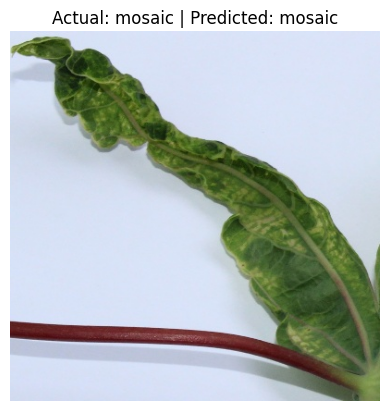

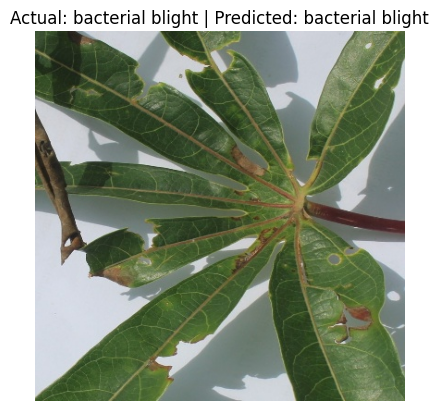

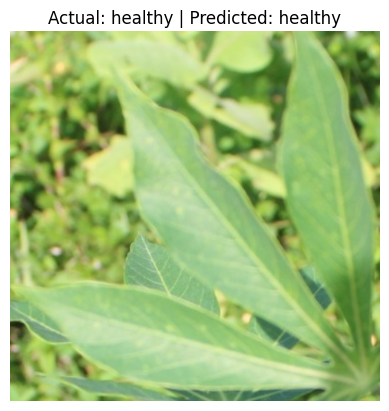

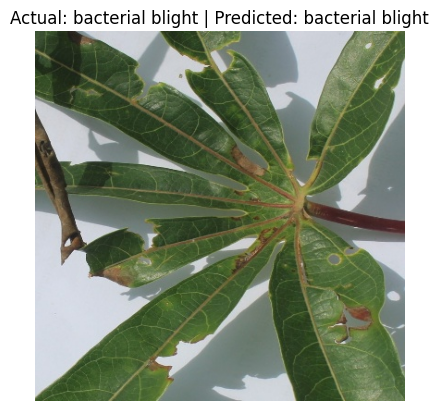

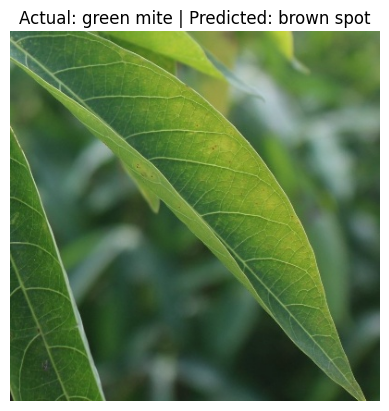

In [24]:
import matplotlib.pyplot as plt

# Tampilkan 5 gambar dari test set beserta prediksi
sample_indices = np.random.choice(len(labels_test_svm), 5, replace=False)

for idx in sample_indices:
    # Path gambar asli dari dataset
    class_folder = class_names[labels_test_svm[idx]]
    test_image_folder = os.path.join(test_path, class_folder)
    test_image_file = os.listdir(test_image_folder)[0]  # asumsi nama gambar urut, bisa diganti lebih tepat
    image_path = os.path.join(test_image_folder, test_image_file)

    # Baca dan tampilkan gambar
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.title(f"Actual: {class_names[labels_test_svm[idx]]} | Predicted: {class_names[y_pred_svm[idx]]}")
    plt.axis('off')
    plt.show()

# GoogleNet

In [25]:
# Inisialisasi dataset googlenet
class ImageDataset(Dataset):
    def __init__(self, dataset_path, transform=None):
        self.dataset_path = dataset_path
        self.transform = transform
        self.data = []
        self.labels = []
        self.classes = os.listdir(dataset_path)
        for label, category in enumerate(self.classes):
            folder_path = os.path.join(dataset_path, category)
            if not os.path.isdir(folder_path):
                continue
            for file_name in os.listdir(folder_path):
                file_path = os.path.join(folder_path, file_name)
                if file_path.lower().endswith(('.png', '.jpg', '.jpeg')):
                    self.data.append(file_path)
                    self.labels.append(label)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        image_path = self.data[idx]
        label = self.labels[idx]
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            image = self.transform(image)
        return image, label

In [26]:
# Transformasi data untuk GoogLeNet
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5],[0.5, 0.5, 0.5])
]) 

In [27]:
# DataLoader untuk GoogLeNet
train_dataset = ImageDataset(train_path, transform=transform)
test_dataset = ImageDataset(test_path, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [28]:
# Model GoogLeNet
model = models.googlenet(pretrained=True)
model.fc = nn.Linear(1024, len(os.listdir(train_path)))
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model.eval()

c:\Users\P A V I L I O N\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\P A V I L I O N\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [29]:
# # Training
# num_epochs = 10
# train_losses = []
# train_accuracies = []
# best_acc = 0.0

# for epoch in range(num_epochs):
#     model.train()
#     running_loss = 0.0
#     correct = 0
#     total = 0
#     start_time = time.time()

#     for images, labels in train_loader:
#         images, labels = images.to(device), labels.to(device)
#         optimizer.zero_grad()
#         outputs = model(images)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()

#         running_loss += loss.item()
#         _, predicted = torch.max(outputs, 1)
#         correct += (predicted == labels).sum().item()
#         total += labels.size(0)

#     epoch_loss = running_loss / len(train_loader)
#     epoch_acc = correct / total
#     train_losses.append(epoch_loss)
#     train_accuracies.append(epoch_acc)

#     print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}, Time: {time.time() - start_time:.2f}s")

#     # Simpan model terbaik berdasarkan akurasi training
#     if epoch_acc > best_acc:
#         best_acc = epoch_acc
#         torch.save(model.state_dict(), "D:/KULIAH IT/Skripsi/CODE/googlenet_model.pth")
#         print(f"✅ Model disimpan pada epoch {epoch+1} dengan akurasi terbaik: {best_acc:.4f}")

In [30]:
num_epochs = 10
train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []
best_test_acc = 0.0

for epoch in range(num_epochs):
    # --- Training Phase ---
    model.train()
    running_loss = 0.0
    correct_train, total_train = 0, 0
    start_time = time.time()

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_acc = correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # --- Evaluation Phase ---
    model.eval()
    test_loss = 0.0
    correct_test, total_test = 0, 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_test += (predicted == labels).sum().item()
            total_test += labels.size(0)

    test_loss /= len(test_loader)
    test_acc = correct_test / total_test
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

    # --- Logging Output ---
    print(f"[{epoch+1:02d}/{num_epochs}] ⏱ {time.time() - start_time:.1f}s | "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
          f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}")

    # --- Save Best Model ---
    # Simpan model terbaik berdasarkan akurasi training
    # if test_acc > best_test_acc:
    #     best_test_acc = test_acc
    #     torch.save(model.state_dict(), "D:/KULIAH IT/Skripsi/CODE/googlenet_model.pth")
    #     print(f"✅ Best model disimpan! (Test Acc: {best_test_acc:.4f})")
        
    # Simpan model terbaik berdasarkan akurasi test
    if test_acc > best_test_acc:
        best_test_acc = test_acc
        torch.save(model.state_dict(), "D:/KULIAH IT/Skripsi/CODE/googlenet_model.pth")
        print(f"✅ Best model disimpan! (Test Acc: {best_test_acc:.4f})")


[01/10] ⏱ 366.5s | Train Loss: 0.4841 | Train Acc: 0.8253 | Test Loss: 0.4396 | Test Acc: 0.8310
✅ Best model disimpan! (Test Acc: 0.8310)
[02/10] ⏱ 348.9s | Train Loss: 0.2943 | Train Acc: 0.8932 | Test Loss: 0.2220 | Test Acc: 0.9200
✅ Best model disimpan! (Test Acc: 0.9200)
[03/10] ⏱ 349.9s | Train Loss: 0.2338 | Train Acc: 0.9220 | Test Loss: 0.4929 | Test Acc: 0.8520
[04/10] ⏱ 355.2s | Train Loss: 0.2120 | Train Acc: 0.9295 | Test Loss: 0.2361 | Test Acc: 0.9130
[05/10] ⏱ 349.8s | Train Loss: 0.1810 | Train Acc: 0.9385 | Test Loss: 0.2819 | Test Acc: 0.9070
[06/10] ⏱ 350.9s | Train Loss: 0.1340 | Train Acc: 0.9563 | Test Loss: 0.2567 | Test Acc: 0.9120
[07/10] ⏱ 350.6s | Train Loss: 0.1480 | Train Acc: 0.9497 | Test Loss: 0.3039 | Test Acc: 0.9150
[08/10] ⏱ 352.3s | Train Loss: 0.0994 | Train Acc: 0.9660 | Test Loss: 0.2545 | Test Acc: 0.9250
✅ Best model disimpan! (Test Acc: 0.9250)
[09/10] ⏱ 344.2s | Train Loss: 0.0918 | Train Acc: 0.9692 | Test Loss: 0.4373 | Test Acc: 0.8790
[

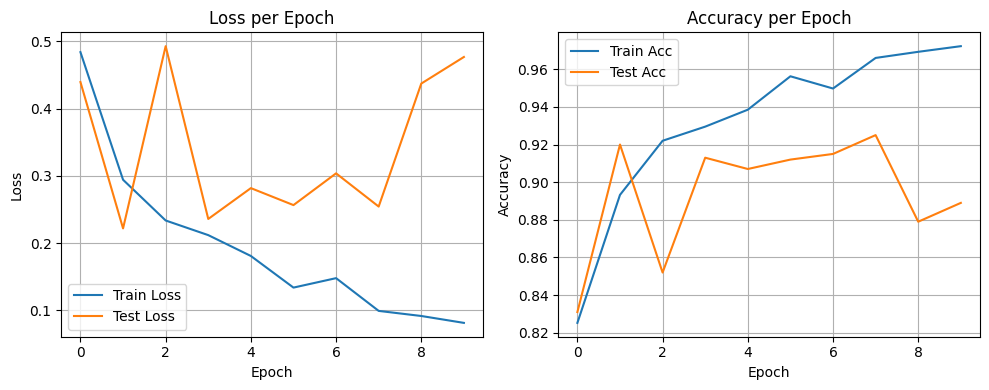

In [31]:
# Plot Loss
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Acc')
plt.plot(test_accuracies, label='Test Acc')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

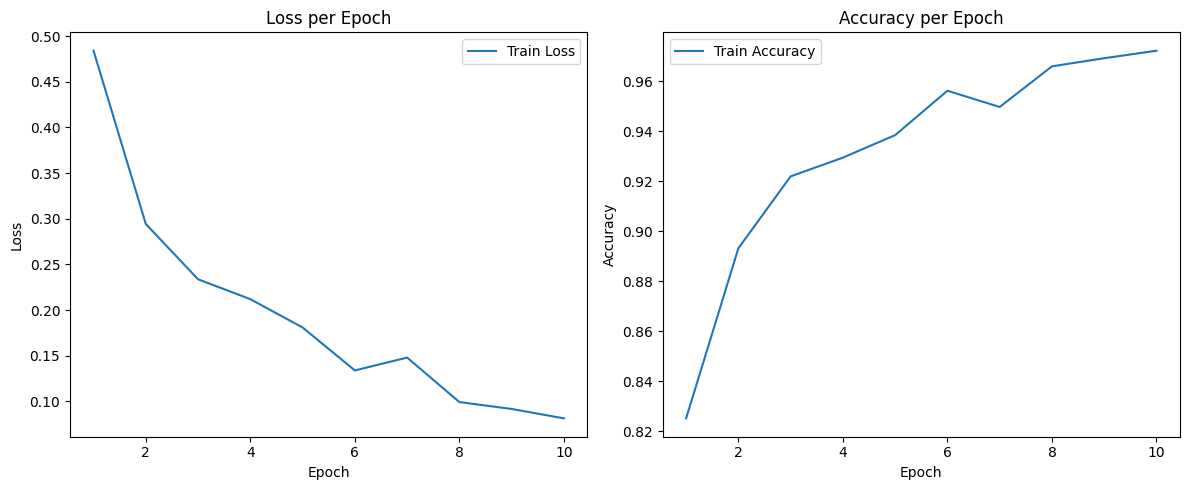

In [32]:
# Plot loss & akurasi
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Loss per Epoch"); plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_accuracies, label='Train Accuracy')
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.title("Accuracy per Epoch"); plt.legend()

plt.tight_layout()
plt.show()

<Figure size 800x500 with 0 Axes>

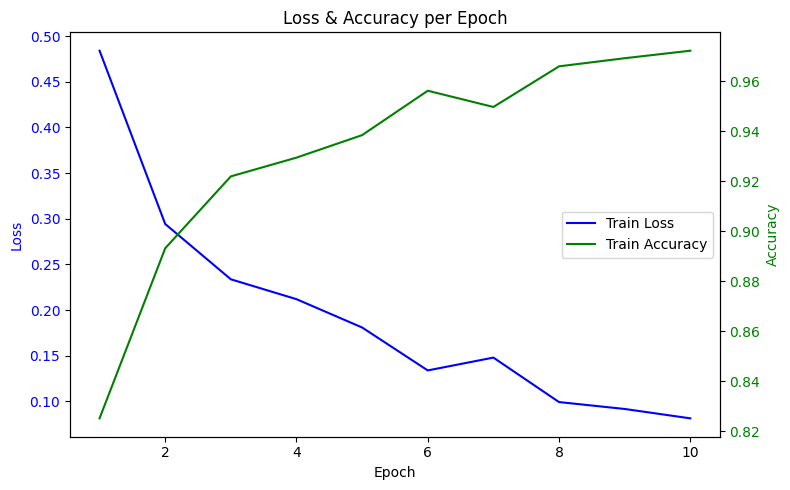

In [33]:
plt.figure(figsize=(8, 5))
epochs = range(1, num_epochs + 1)

fig, ax1 = plt.subplots(figsize=(8, 5))

# Plot loss
ax1.plot(epochs, train_losses, 'b-', label='Train Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.set_title('Loss & Accuracy per Epoch')

# Twin axis for accuracy
ax2 = ax1.twinx()
ax2.plot(epochs, train_accuracies, 'g-', label='Train Accuracy')
ax2.set_ylabel('Accuracy', color='g')
ax2.tick_params(axis='y', labelcolor='g')

# Combine legends
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='center right')

plt.tight_layout()
plt.show()


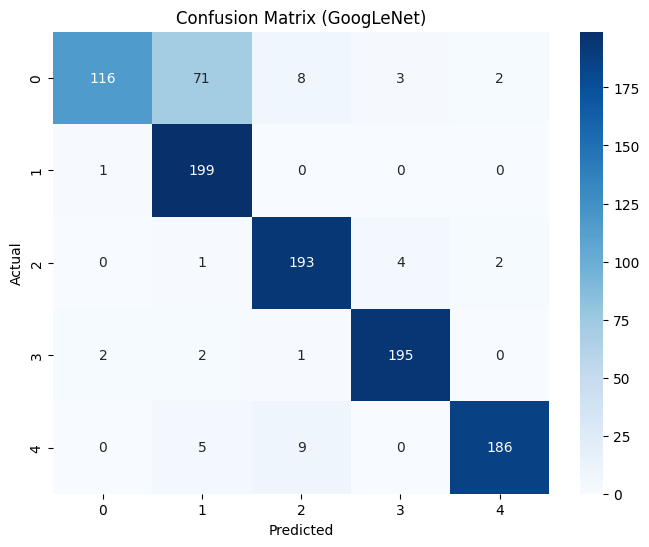

In [34]:
# Confusion Matrix GoogLeNet
all_preds, all_labels = [], []
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cmgl = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cmgl, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (GoogLeNet)')
plt.show()

In [35]:
model.load_state_dict(torch.load("D:/KULIAH IT/Skripsi/CODE/googlenet_model.pth", map_location=device))

C:\Users\P A V I L I O N\AppData\Local\Temp\ipykernel_80456\2116821251.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("D:/KULIAH IT/Skr

<All keys matched successfully>

In [36]:
model.eval()
all_preds = []
all_labels = []
all_paths = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

In [37]:
print("\nClassification Report (GoogLeNet):")
print(classification_report(all_labels, all_preds))


Classification Report (GoogLeNet):
              precision    recall  f1-score   support

           0       0.90      0.83      0.87       200
           1       0.89      0.92      0.91       200
           2       0.95      0.92      0.93       200
           3       0.90      0.99      0.95       200
           4       0.98      0.96      0.97       200

    accuracy                           0.93      1000
   macro avg       0.93      0.93      0.92      1000
weighted avg       0.93      0.93      0.92      1000



In [38]:
# Mendapatkan nama kelas
class_names = sorted(os.listdir(test_path))

# Buat DataFrame
df_results = pd.DataFrame({
    'Actual Label': [class_names[i] for i in all_labels],
    'Predicted Label': [class_names[i] for i in all_preds]
})

print(df_results.head(10))  # Menampilkan 10 prediksi pertama


       Actual Label   Predicted Label
0  bacterial blight  bacterial blight
1  bacterial blight  bacterial blight
2  bacterial blight  bacterial blight
3  bacterial blight        green mite
4  bacterial blight  bacterial blight
5  bacterial blight  bacterial blight
6  bacterial blight        brown spot
7  bacterial blight        brown spot
8  bacterial blight  bacterial blight
9  bacterial blight  bacterial blight
